#### Following [wmt analysis: full3D_tutorial.ipynb](https://github.com/hdrake/xwmt/blob/main/examples/full3D_tutorial.ipynb) and [Baltic example](https://github.com/hdrake/xwmb/blob/main/examples/Baltic_example.ipynb)


In [327]:
cd

/data/homezvol3/mariant3


In [1]:
import xarray as xr
import numpy as np

In [2]:
import xwmb
import xwmt
import xgcm

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
xwmb.__version__, xwmt.__version__, xgcm.__version__

('0.0.1', '0.0.3', '0.8.2.dev15+g7492277')

In [5]:
hfdrake_path = "/pub/hfdrake/datasets/CM4_MHW_blobs/"
mt_path = "/pub/mariant3/WarmWaterMasses/03_3D-analysis/"
ds = xr.open_mfdataset(f"{hfdrake_path}/data/WMT_monthly/ocean_month_rho2.0186*", chunks={"xh":360, "yh":270, "time":1}) #chunks={'time':1})
snap = xr.open_mfdataset(f"{hfdrake_path}/data/WMT_monthly/ocean_month_rho2_snap.0186*", chunks={"xh":360, "yh":270, "time":1}) #chunks={'time':1})
static = xr.open_mfdataset(f"{hfdrake_path}/data/WMT_monthly/ocean_month_rho2.static.nc", chunks={"xh":360, "yh":270}) #chunks={'time':1})
wmt = xr.open_mfdataset(f"{mt_path}wmt.nc")

In [6]:
# Merge snapshots with time-averages
snap = snap.rename({
    **{'time':'time_bounds'},
    **{v:f"{v}_bounds" for v in snap.data_vars}
})
ds = xr.merge([ds.sel(time=ds.time[1:]), snap])

In [7]:
# Add core coordinates of static to ds
ds = ds.assign_coords({
    "areacello": xr.DataArray(static["areacello"].values, dims=('yh', 'xh',)), # Required for area-integration
    "lon": xr.DataArray(static["geolon"].values, dims=('yh', 'xh',)), # Required for calculating density if not already provided!
    "lat": xr.DataArray(static["geolat"].values, dims=('yh', 'xh',)), # Required for calculating density if not already provided!
    "xq": xr.DataArray(static["xq"].values, dims=('xq',)),
    "yq": xr.DataArray(static["yq"].values, dims=('yq',)),
    "deptho": xr.DataArray(static["deptho"].values, dims=('yh', 'xh',)),
    "geolon": xr.DataArray(static["geolon"].values, dims=('yh', 'xh',)),
    "geolat": xr.DataArray(static["geolat"].values, dims=('yh', 'xh',)),
    "geolon_c": xr.DataArray(static["geolon_c"].values, dims=('yq', 'xq',)),
    "geolat_c": xr.DataArray(static["geolat_c"].values, dims=('yq', 'xq',)),
})

# xgcm grid for dataset
coords = {
    'X': {'center': 'xh', 'right': 'xq'},
    'Y': {'center': 'yh', 'right': 'yq'},
    'Z': {'center': 'rho2_l', 'outer': 'rho2_i'}
}
metrics = {
    ('X','Y'): "areacello", # Required for area-integration
}

ds['tos'] = ds['thetao'].isel(rho2_l=0)
ds['sos'] = ds['so'].isel(rho2_l=0)

grid = xgcm.Grid(ds.copy(), coords=coords, metrics=metrics, boundary={'X':'extend', 'Y':'extend', 'Z':'extend'}, autoparse_metadata=False)

In [8]:
wm = xwmt.WaterMass(grid)

In [9]:
ds

<xarray.Dataset>
Dimensions:                         (time: 59, rho2_l: 74, yh: 1080, xh: 1440,
                                     nv: 2, rho2_i: 75, yq: 1080,
                                     time_bounds: 60, xq: 1440)
Coordinates: (12/17)
  * nv                              (nv) float64 1.0 2.0
  * rho2_i                          (rho2_i) float64 997.0 ... 1.039e+03
  * rho2_l                          (rho2_l) float64 1.004e+03 ... 1.038e+03
  * time                            (time) object 0186-02-15 00:00:00 ... 019...
  * xh                              (xh) float64 -299.7 -299.5 ... 59.78 60.03
  * yh                              (yh) float64 -80.39 -80.31 ... 89.84 89.95
    ...                              ...
  * yq                              (yq) float64 -80.35 -80.27 ... 89.89 90.0
    deptho                          (yh, xh) float32 nan nan nan ... nan nan nan
    geolon                          (yh, xh) float32 -299.7 -299.5 ... 60.0 60.0
    geolat                          (yh, xh) float32 -79.81 -79.81 ... 64.11
    geolon_c                        (yq, xq) float32 -299.6 -299.4 ... -300.0
    geolat_c                        (yq, xq) float32 -79.77 -79.77 ... 64.06
Data variables: (12/36)
    S_advection_xy                  (time, rho2_l, yh, xh) float32 dask.array<chunksize=(1, 74, 270, 360), meta=np.ndarray>
    average_DT                      (time) timedelta64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
    average_T1                      (time) object dask.array<chunksize=(1,), meta=np.ndarray>
    average_T2                      (time) object dask.array<chunksize=(1,), meta=np.ndarray>
    time_bnds                       (time, nv) object dask.array<chunksize=(1, 2), meta=np.ndarray>
    Sh_tendency_vert_remap          (time, rho2_l, yh, xh) float32 dask.array<chunksize=(1, 74, 270, 360), meta=np.ndarray>
    ...                              ...
    so_bounds                       (time_bounds, rho2_l, yh, xh) float32 dask.array<chunksize=(1, 74, 270, 360), meta=np.ndarray>
    thetao_bounds                   (time_bounds, rho2_l, yh, xh) float32 dask.array<chunksize=(1, 74, 270, 360), meta=np.ndarray>
    thkcello_bounds                 (time_bounds, rho2_l, yh, xh) float32 dask.array<chunksize=(1, 74, 270, 360), meta=np.ndarray>
    volcello_bounds                 (time_bounds, rho2_l, yh, xh) float32 dask.array<chunksize=(1, 74, 270, 360), meta=np.ndarray>
    tos                             (time, yh, xh) float32 dask.array<chunksize=(1, 270, 360), meta=np.ndarray>
    sos                             (time, yh, xh) float32 dask.array<chunksize=(1, 270, 360), meta=np.ndarray>
Attributes:
    filename:            ocean_month_rho2.018601-019012.S_advection_xy.nc
    title:               CM4_piControl_C_restartyear148
    associated_files:    areacello: 01860101.ocean_static.nc
    grid_type:           regular
    grid_tile:           N/A
    external_variables:  volcello areacello

In [10]:
import xbudget
budgets_dict = xbudget.load_preset_budget(model="MOM6_3Donly")
xbudget.collect_budgets(grid._ds, budgets_dict)

(10.0, 38.0)

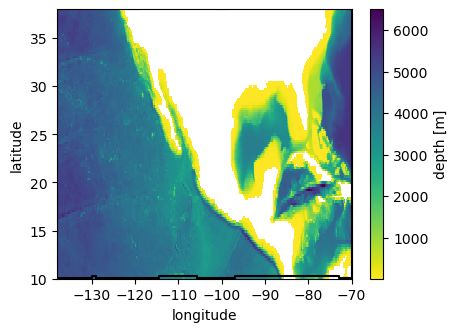

In [11]:
import numpy as np
import regionate
import matplotlib.pyplot as plt

# Note: the properties of this region are quite different from the rest of the Baltic!
name = "MANSO"
#lons = np.array([8.,   20.,  29., 24.5, 24.5, 26.1, 17.5, 11.5])
#lons = np.arange([-138, 0, 3.4])
lons = np.array([-138.,-120.,-100., -70., -70., -100., -120., -138.])
#lats = np.arange(8, 49, 1)
lats = np.array([10., 10., 10., 10., 38., 38., 38., 38.])
#lats = np.array([53.5, 53.5, 54.5,  59.,  61.,  63., 64.5,  62.])
manso_region = regionate.GriddedRegion(name, lons, lats, grid)

plt.figure(figsize=(4.75,3.5))
pc = plt.pcolor(
    grid._ds['geolon_c'],
    grid._ds['geolat_c'],
    grid._ds['deptho'],
    cmap="viridis_r"
)
plt.colorbar(pc, label="depth [m]")
plt.plot(regionate.loop(manso_region.lons), regionate.loop(manso_region.lats), color="k");
plt.xlabel("longitude");
plt.ylabel("latitude");
plt.xlim(np.min(lons), np.max(lons))
plt.ylim(np.min(lats), np.max(lats))

#plt.xlim(-200,5)
#plt.ylim(-10,80)

In [12]:
#To find indices:
print(np.abs(grid._ds.xh - np.min(manso_region.lons)).argmin().values)
print(np.abs(grid._ds.xh - np.max(manso_region.lons)).argmin().values)
print(np.abs(grid._ds.yh - np.min(manso_region.lats)).argmin().values)
print(np.abs(grid._ds.yh - np.max(manso_region.lats)).argmin().values)

650
918
544
673


In [233]:
print(grid._ds.xh.sel(xh=manso_region.lons[0],method='nearest').values)
print(grid._ds.yh.sel(yh=manso_region.lats[0],method='nearest').values)
print(grid._ds.xh.sel(xh=np.max(manso_region.lons),method='nearest').values)
print(grid._ds.yh.sel(yh=np.max(manso_region.lats),method='nearest').values)

-137.93675712497367
10.195760139144719
-69.90677907692074
39.065640371236086


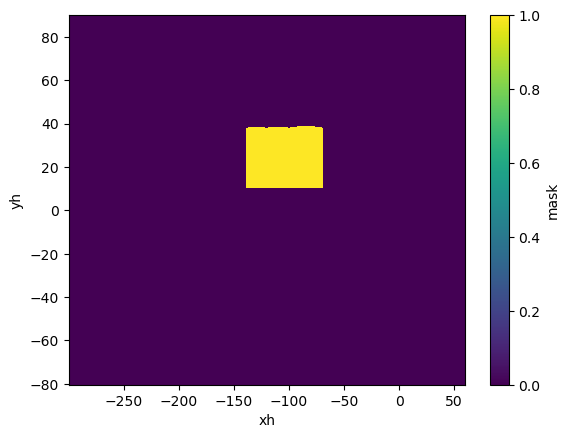

In [13]:
manso_region.mask.plot()

In [14]:
import warnings

lam = "heat"
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    wmb = xwmb.WaterMassBudget(
        grid,
        budgets_dict,
        manso_region.mask,
        assert_zero_transport=True
    )
    wmb.mass_budget(lam, greater_than=True, default_bins=True)
    #wmb.wmt.load()
    wmt = wmb.wmt

In [ ]:
wmb_bounds_greater_than = wmb.grid._ds['mass_bounds_greater_than'].load()

In [19]:
wmb_bounds_greater_than = wmb.grid._ds['mass_bounds_greater_than']

In [16]:
wmt

<xarray.Dataset>
Dimensions:                                    (time: 59, thetao_l_target: 440,
                                                thetao_i_target: 441,
                                                time_bounds: 60)
Coordinates:
  * time                                       (time) object 0186-02-15 00:00...
  * thetao_l_target                            (thetao_l_target) float64 -4.0...
  * thetao_i_target                            (thetao_i_target) float64 -4.0...
  * time_bounds                                (time_bounds) object 0186-02-0...
Data variables: (12/20)
    surface_ocean_flux_advective_negative_rhs  (time, thetao_l_target) float64 dask.array<chunksize=(1, 440), meta=np.ndarray>
    surface_exchange_flux                      (time, thetao_l_target) float64 dask.array<chunksize=(1, 440), meta=np.ndarray>
    advection                                  (time, thetao_l_target) float64 dask.array<chunksize=(1, 440), meta=np.ndarray>
    frazil_ice                                 (time, thetao_l_target) float64 dask.array<chunksize=(1, 440), meta=np.ndarray>
    surface_ocean_flux_advective_negative_lhs  (time, thetao_l_target) float64 dask.array<chunksize=(1, 440), meta=np.ndarray>
    diffusion                                  (time, thetao_l_target) float64 dask.array<chunksize=(1, 440), meta=np.ndarray>
    ...                                         ...
    mass_source                                (time, thetao_l_target) float32 dask.array<chunksize=(1, 440), meta=np.ndarray>
    overturning                                (time, thetao_l_target) float32 dask.array<chunksize=(1, 440), meta=np.ndarray>
    Leibniz_material_derivative                (time, thetao_l_target) float64 dask.array<chunksize=(1, 440), meta=np.ndarray>
    spurious_numerical_mixing                  (time, thetao_l_target) float64 dask.array<chunksize=(1, 440), meta=np.ndarray>
    advection_plus_BC                          (time, thetao_l_target) float64 dask.array<chunksize=(1, 440), meta=np.ndarray>
    diabatic_advection                         (time, thetao_l_target) float64 dask.array<chunksize=(1, 440), meta=np.ndarray>

In [ ]:
wmb_bounds_greater_than.mean('time_bounds').sel(thetao_i_target=29, method='nearest').plot()
wmb_bounds_greater_than.isel(time_bounds=7).plot()
#wmb_bounds_greater_than.isel(time_bounds=19).plot()
#wmb_bounds_greater_than.isel(time_bounds=31).plot()
#wmb_bounds_greater_than.isel(time_bounds=43).plot()
plt.yscale('log')

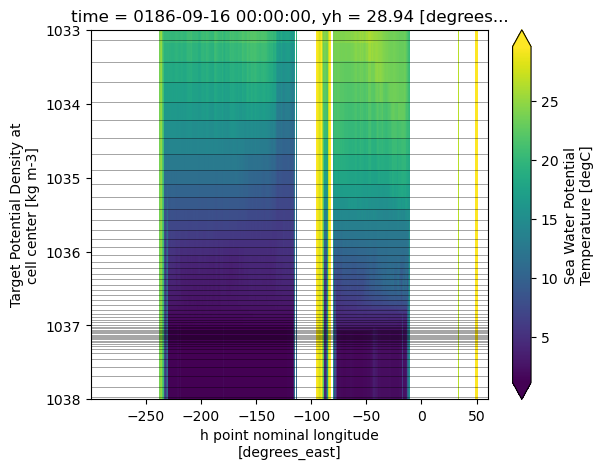

In [17]:
ds.thetao.isel(time=7).sel(yh=29, method="nearest").plot(robust = True)
plt.ylim(1038, 1033)
for rho2 in ds.rho2_i:
    plt.axhline(rho2, color = 'k', lw = '0.5', alpha = 0.5)

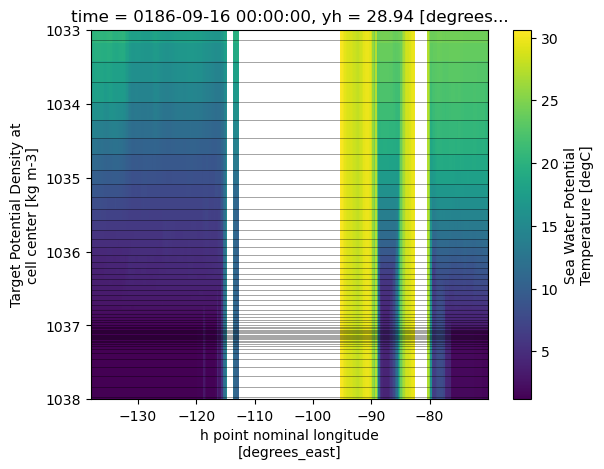

In [18]:
ds.thetao.isel(time=7).sel(yh=29, method="nearest").sel(xh=slice(-138,-70)).plot()
plt.ylim(1038, 1033)
for rho2 in ds.rho2_i:
    plt.axhline(rho2, color = 'k', lw = '0.5', alpha = 0.5)

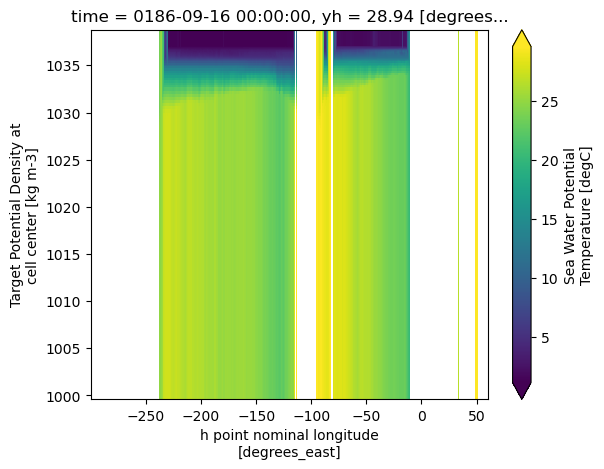

In [19]:
ds.thetao.isel(time=7).sel(yh=29, method="nearest").plot(robust = True)

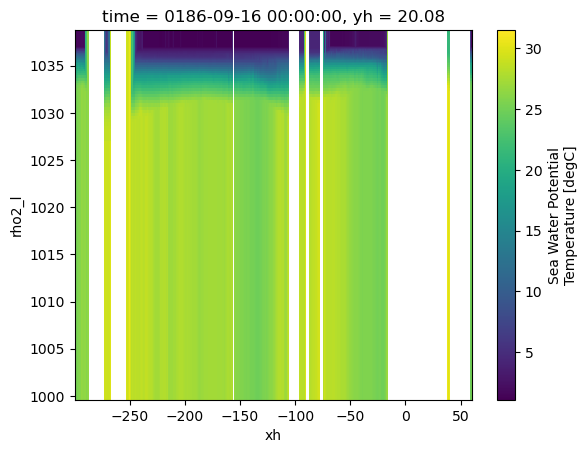

In [255]:
wm.grid._ds['thetao'].isel(time=7).sel(yh=20, method="nearest").plot()

<a list of 10 text.Text objects>

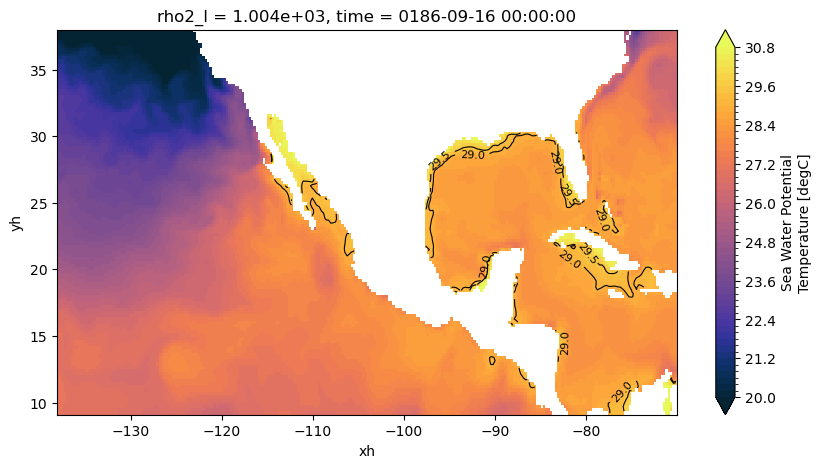

In [328]:
plt.figure(figsize=(10,5))
wm.grid._ds['thetao'].isel(time=7).isel(rho2_l=0).sel(yh=slice(9,38)).sel(xh=slice(-138,-70)).plot(levels=np.arange(20, 31, 0.2),
                                                                                                    colors=cmocean.cm.thermal, 
                                                                                                    add_colorbar=True)

C = wm.grid._ds['thetao'].isel(time=7).isel(rho2_l=0).sel(yh=slice(9,38)).sel(xh=slice(-138,-70)).plot.contour(levels=np.arange(29, 30, 0.5),#[29],
                                                                                                               colors='k',
                                                                                                               linewidths=0.8,
                                                                                                               linestyles='solid'
)

plt.clabel(C, inline=True,fontsize=8) #, inline_spacing=5)

#plt.axhline(y=29, color='black', linestyle='--')
#plt.title(f"{wm.grid._ds.thetao.isel(time=0).time.values},{wm.grid._ds.thetao.sel(yh=slice(27,38),method='nearest').yh.values},{wm.grid._ds.thetao.isel(rho2_l=20).rho2_l.values}")

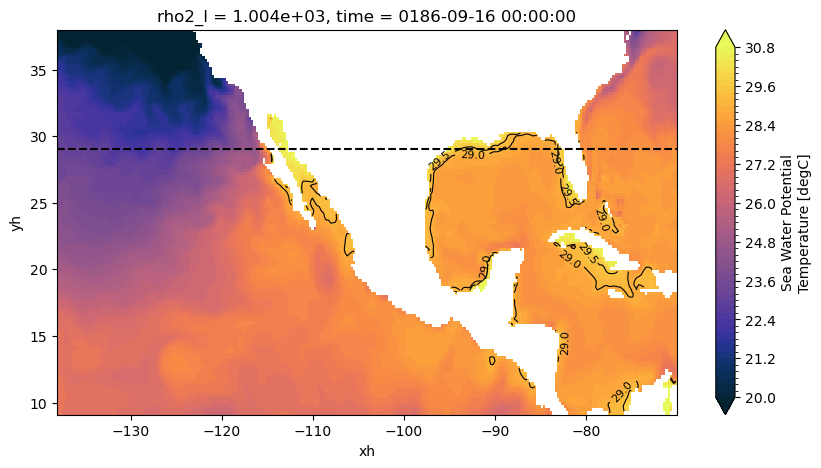

In [331]:
plt.figure(figsize=(10,5))
wm.grid._ds['thetao'].isel(time=7).isel(rho2_l=0).sel(yh=slice(9,38)).sel(xh=slice(-138,-70)).plot(levels=np.arange(20, 31, 0.2),
                                                                                                    colors=cmocean.cm.thermal, 
                                                                                                    add_colorbar=True)

C = wm.grid._ds['thetao'].isel(time=7).isel(rho2_l=0).sel(yh=slice(9,38)).sel(xh=slice(-138,-70)).plot.contour(levels=np.arange(29, 30, 0.5),#[29],
                                                                                                               colors='k',
                                                                                                               linewidths=0.8,
                                                                                                               linestyles='solid'
)

plt.clabel(C, inline=True,fontsize=8) #, inline_spacing=5)

plt.axhline(y=29, color='k', linestyle='--')
#plt.title(f"{wm.grid._ds.thetao.isel(time=0).time.values},{wm.grid._ds.thetao.sel(yh=slice(27,38),method='nearest').yh.values},{wm.grid._ds.thetao.isel(rho2_l=20).rho2_l.values}")

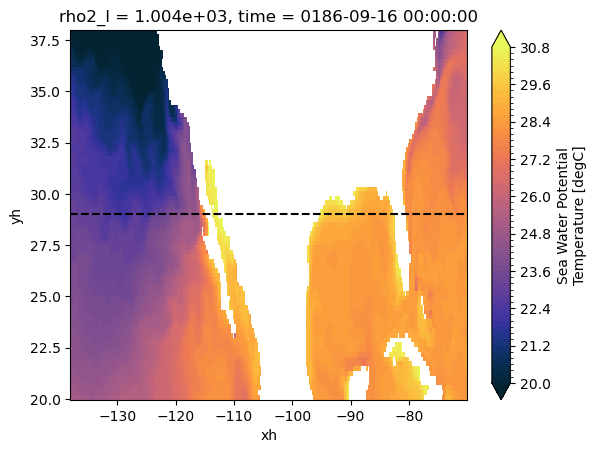

In [299]:
#plt.figure(figsize=(7,3))
wm.grid._ds['thetao'].isel(time=7).isel(rho2_l=0).sel(yh=slice(20,38)).sel(xh=slice(-138,-70)).plot(levels=np.arange(20, 31, 0.2),
                                                                                                    colors=cmocean.cm.thermal, 
                                                                                                    add_colorbar=True)

plt.contour(
    wm.grid._ds['thetao'].isel(time=7).isel(rho2_l=0).sel(yh=slice(20,38)).sel(xh=slice(-138,-70)),
    levels=[29],
    colors='black',
    linestyles='--'
)
plt.axhline(y=29, color='black', linestyle='--')
#plt.title(f"{wm.grid._ds.thetao.isel(time=0).time.values},{wm.grid._ds.thetao.sel(yh=slice(27,38),method='nearest').yh.values},{wm.grid._ds.thetao.isel(rho2_l=20).rho2_l.values}")

In [271]:
wm.get_density()

In [49]:
temp = wm.grid._ds['thetao'].isel(time=7).sel(yh=29, method="nearest").sel(xh=slice(-138,-70)).compute()
z_section = wm.grid._ds['z'].isel(time=7).sel(yh=29, method="nearest").sel(xh=slice(-138,-70)).compute()

(100.0, 0.0)

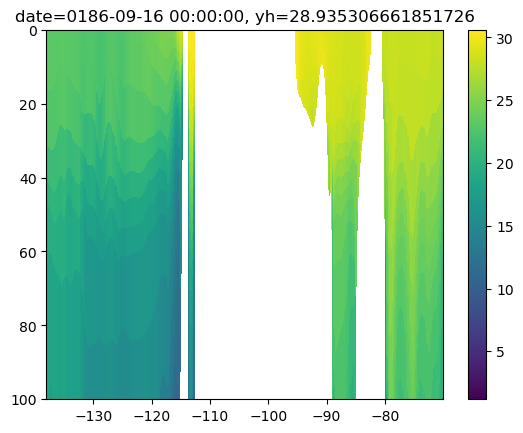

In [50]:
import matplotlib.pyplot as plt

plt.pcolor(
    z_section.xh*xr.ones_like(z_section.rho2_l),
    z_section,
    temp.transpose()
)


plt.colorbar()
plt.title(f'date={z_section.time.values}, yh={z_section.yh.values}')
plt.ylim(100, 0)

In [323]:
temp = wm.grid._ds['thetao'].isel(time=0).sel(yh=29, method="nearest").sel(xh=slice(-138,-70)).compute()
z_section = wm.grid._ds['z'].isel(time=0).sel(yh=29, method="nearest").sel(xh=slice(-138,-70)).compute()

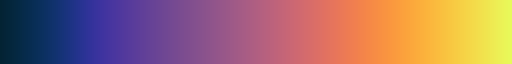

In [324]:
cmocean.cm.thermal

In [325]:
y=z_section.time.dt.year.values
m=z_section.time.dt.month.values
d=z_section.time.dt.day.values

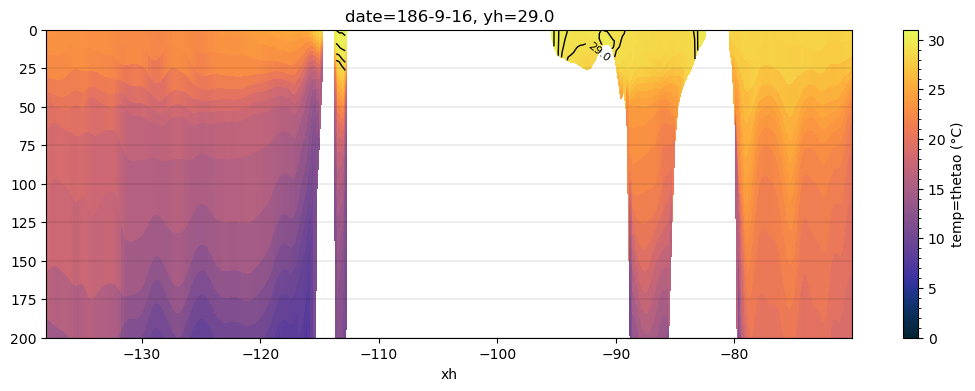

In [232]:
import cmocean


plt.figure(figsize=(13,4))

plt.pcolor(
    z_section.xh * xr.ones_like(z_section.rho2_l),
    z_section,
    temp.transpose(),
    vmin=0, 
    vmax=31,
    cmap = cmocean.cm.thermal
)

colorbar = plt.colorbar()
colorbar.set_label('temp=thetao (°C)')  # Add title to the colorbar
colorbar.set_ticks(np.arange(0, 31, 5))  # Set tick marks on the colorbar
colorbar.set_ticks(np.arange(1, 31, 1), minor=True)
#plt.colorbar()
#plt.add_colorbar=True

# Adding contour lines for temperature
contour = plt.contour(
    z_section.xh * xr.ones_like(z_section.rho2_l),
    z_section,
    temp.transpose(),
    levels=np.arange(29, 31, 0.5), #levels=np.arange(20, 30, 0.5) [29]
    #levels=[30],
    colors='black',
    linewidths=1,
    linestyles='solid',
    #linewidth=0.1,
    add_colorbar=True,
)

plt.ylim(200, 0)
plt.clabel(contour, inline=True,fontsize=8) #, inline_spacing=5)
plt.xlabel('xh')  # Add label for the x-axis
#plt.ylabel('Y Label')  # Add label for the y-axis

plt.title(f'date={y}-{m}-{d}, yh={np.round(z_section.yh.values)}')
plt.grid(axis="y",color = "k",linestyle = "-",linewidth=0.1)
plt.show()

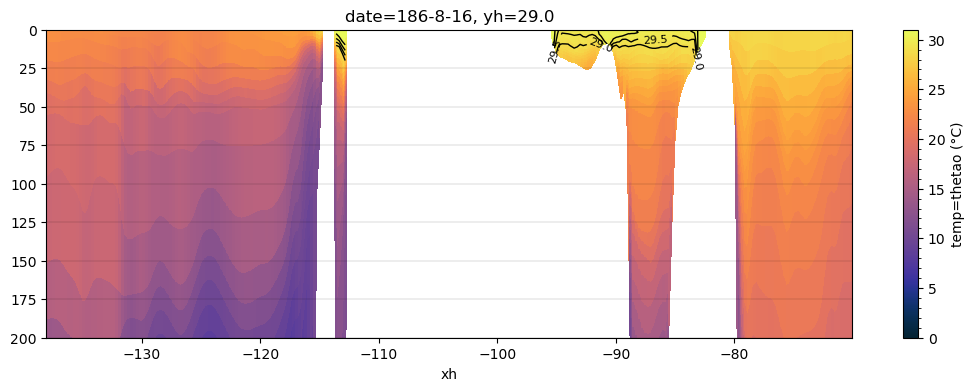

In [310]:
import cmocean


plt.figure(figsize=(13,4))

plt.pcolor(
    z_section.xh * xr.ones_like(z_section.rho2_l),
    z_section,
    temp.transpose(),
    vmin=0, 
    vmax=31,
    cmap = cmocean.cm.thermal
)

colorbar = plt.colorbar()
colorbar.set_label('temp=thetao (°C)')  # Add title to the colorbar
colorbar.set_ticks(np.arange(0, 31, 5))  # Set tick marks on the colorbar
colorbar.set_ticks(np.arange(1, 31, 1), minor=True)
#plt.colorbar()
#plt.add_colorbar=True

# Adding contour lines for temperature
contour = plt.contour(
    z_section.xh * xr.ones_like(z_section.rho2_l),
    z_section,
    temp.transpose(),
    levels=np.arange(29, 31, 0.5), #levels=np.arange(20, 30, 0.5) [29]
    #levels=[30],
    colors='black',
    linewidths=1,
    linestyles='solid',
    #linewidth=0.1,
    add_colorbar=True,
)

plt.ylim(200, 0)
plt.clabel(contour, inline=True,fontsize=8) #, inline_spacing=5)
plt.xlabel('xh')  # Add label for the x-axis
#plt.ylabel('Y Label')  # Add label for the y-axis

plt.title(f'date={y}-{m}-{d}, yh={np.round(z_section.yh.values)}')
plt.grid(axis="y",color = "k",linestyle = "-",linewidth=0.1)
plt.show()

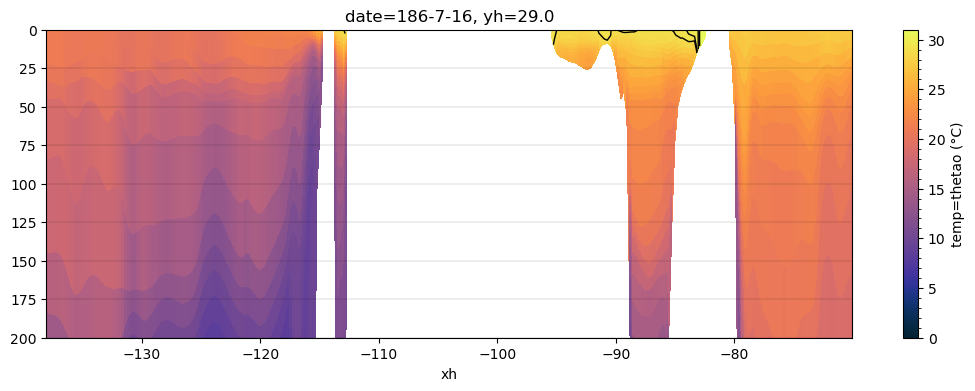

In [314]:
import cmocean


plt.figure(figsize=(13,4))

plt.pcolor(
    z_section.xh * xr.ones_like(z_section.rho2_l),
    z_section,
    temp.transpose(),
    vmin=0, 
    vmax=31,
    cmap = cmocean.cm.thermal
)

colorbar = plt.colorbar()
colorbar.set_label('temp=thetao (°C)')  # Add title to the colorbar
colorbar.set_ticks(np.arange(0, 31, 5))  # Set tick marks on the colorbar
colorbar.set_ticks(np.arange(1, 31, 1), minor=True)
#plt.colorbar()
#plt.add_colorbar=True

# Adding contour lines for temperature
contour = plt.contour(
    z_section.xh * xr.ones_like(z_section.rho2_l),
    z_section,
    temp.transpose(),
    levels=np.arange(29, 31, 0.5), #levels=np.arange(20, 30, 0.5) [29]
    #levels=[30],
    colors='black',
    linewidths=1,
    linestyles='solid',
    #linewidth=0.1,
    add_colorbar=True,
)

plt.ylim(200, 0)
plt.clabel(contour, inline=True,fontsize=8) #, inline_spacing=5)
plt.xlabel('xh')  # Add label for the x-axis
#plt.ylabel('Y Label')  # Add label for the y-axis

plt.title(f'date={y}-{m}-{d}, yh={np.round(z_section.yh.values)}')
plt.grid(axis="y",color = "k",linestyle = "-",linewidth=0.1)
plt.show()

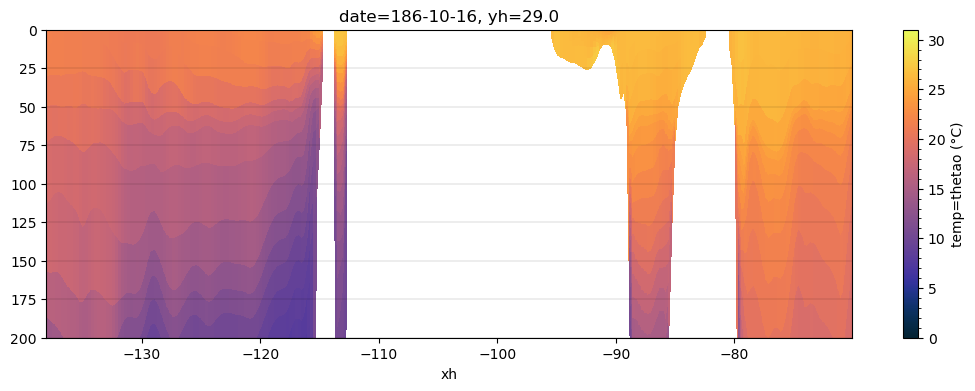

In [318]:
import cmocean


plt.figure(figsize=(13,4))

plt.pcolor(
    z_section.xh * xr.ones_like(z_section.rho2_l),
    z_section,
    temp.transpose(),
    vmin=0, 
    vmax=31,
    cmap = cmocean.cm.thermal
)

colorbar = plt.colorbar()
colorbar.set_label('temp=thetao (°C)')  # Add title to the colorbar
colorbar.set_ticks(np.arange(0, 31, 5))  # Set tick marks on the colorbar
colorbar.set_ticks(np.arange(1, 31, 1), minor=True)
#plt.colorbar()
#plt.add_colorbar=True

# Adding contour lines for temperature
contour = plt.contour(
    z_section.xh * xr.ones_like(z_section.rho2_l),
    z_section,
    temp.transpose(),
    levels=np.arange(29, 31, 0.5), #levels=np.arange(20, 30, 0.5) [29]
    #levels=[30],
    colors='black',
    linewidths=1,
    linestyles='solid',
    #linewidth=0.1,
    add_colorbar=True,
)

plt.ylim(200, 0)
plt.clabel(contour, inline=True,fontsize=8) #, inline_spacing=5)
plt.xlabel('xh')  # Add label for the x-axis
#plt.ylabel('Y Label')  # Add label for the y-axis

plt.title(f'date={y}-{m}-{d}, yh={np.round(z_section.yh.values)}')
plt.grid(axis="y",color = "k",linestyle = "-",linewidth=0.1)
plt.show()

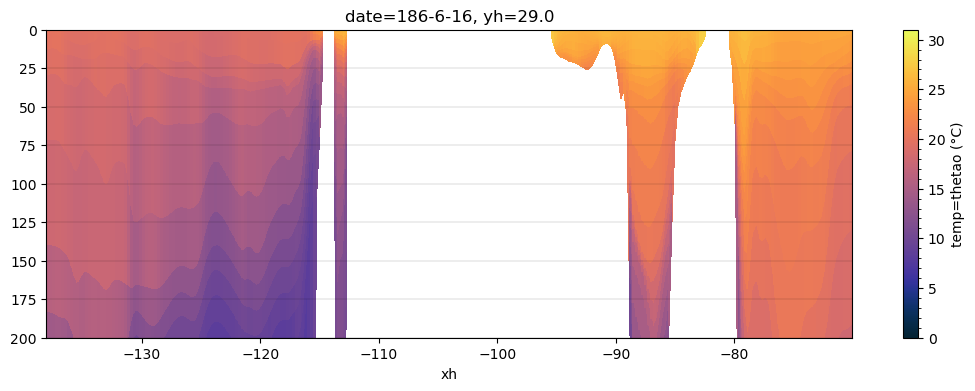

In [322]:
import cmocean


plt.figure(figsize=(13,4))

plt.pcolor(
    z_section.xh * xr.ones_like(z_section.rho2_l),
    z_section,
    temp.transpose(),
    vmin=0, 
    vmax=31,
    cmap = cmocean.cm.thermal
)

colorbar = plt.colorbar()
colorbar.set_label('temp=thetao (°C)')  # Add title to the colorbar
colorbar.set_ticks(np.arange(0, 31, 5))  # Set tick marks on the colorbar
colorbar.set_ticks(np.arange(1, 31, 1), minor=True)
#plt.colorbar()
#plt.add_colorbar=True

# Adding contour lines for temperature
contour = plt.contour(
    z_section.xh * xr.ones_like(z_section.rho2_l),
    z_section,
    temp.transpose(),
    levels=np.arange(29, 31, 0.5), #levels=np.arange(20, 30, 0.5) [29]
    #levels=[30],
    colors='black',
    linewidths=1,
    linestyles='solid',
    #linewidth=0.1,
    add_colorbar=True,
)

plt.ylim(200, 0)
plt.clabel(contour, inline=True,fontsize=8) #, inline_spacing=5)
plt.xlabel('xh')  # Add label for the x-axis
#plt.ylabel('Y Label')  # Add label for the y-axis

plt.title(f'date={y}-{m}-{d}, yh={np.round(z_section.yh.values)}')
plt.grid(axis="y",color = "k",linestyle = "-",linewidth=0.1)
plt.show()

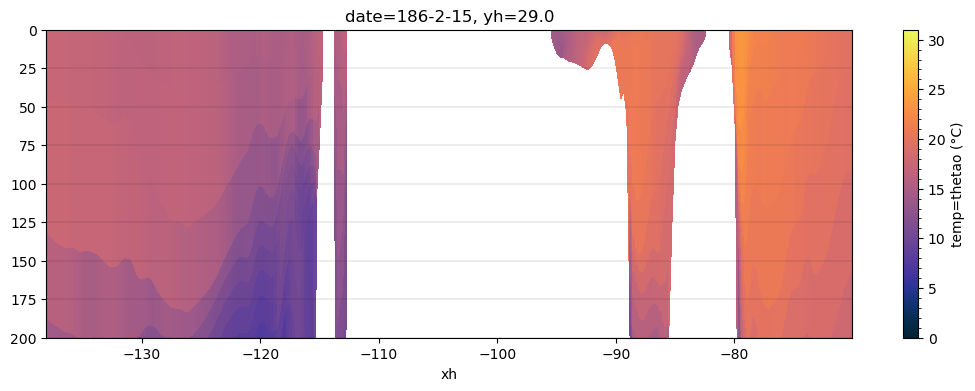

In [326]:
import cmocean


plt.figure(figsize=(13,4))

plt.pcolor(
    z_section.xh * xr.ones_like(z_section.rho2_l),
    z_section,
    temp.transpose(),
    vmin=0, 
    vmax=31,
    cmap = cmocean.cm.thermal
)

colorbar = plt.colorbar()
colorbar.set_label('temp=thetao (°C)')  # Add title to the colorbar
colorbar.set_ticks(np.arange(0, 31, 5))  # Set tick marks on the colorbar
colorbar.set_ticks(np.arange(1, 31, 1), minor=True)
#plt.colorbar()
#plt.add_colorbar=True

# Adding contour lines for temperature
contour = plt.contour(
    z_section.xh * xr.ones_like(z_section.rho2_l),
    z_section,
    temp.transpose(),
    levels=np.arange(29, 31, 0.5), #levels=np.arange(20, 30, 0.5) [29]
    #levels=[30],
    colors='black',
    linewidths=1,
    linestyles='solid',
    #linewidth=0.1,
    add_colorbar=True,
)

plt.ylim(200, 0)
plt.clabel(contour, inline=True,fontsize=8) #, inline_spacing=5)
plt.xlabel('xh')  # Add label for the x-axis
#plt.ylabel('Y Label')  # Add label for the y-axis

plt.title(f'date={y}-{m}-{d}, yh={np.round(z_section.yh.values)}')
plt.grid(axis="y",color = "k",linestyle = "-",linewidth=0.1)
plt.show()